<a href="https://colab.research.google.com/github/joheras/MusicaCatedralStoDomingoIER/blob/main/Notebooks/SacarM%C3%BAsica/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ice Vision

## Librerías

In [1]:
%%capture
!pip install icevision[all]==0.5.1

In [1]:
from icevision.all import *

In [2]:
%%capture
!unzip Musica.zip

## Funciones

In [3]:
def abrirImagen(path):
  return cv2.imread(str(path))

def imagenDeImagen(img,h=16,w=16):
  plt.figure(figsize = (h,w))
  plt.imshow(img)
  plt.show()

def mostrarImagen(path):
  img=cv2.imread(str(path))
  imagenDeImagen(img)
  return abrirImagen(img)


def imgAnotada(path):
  colores = {'claved':(119, 90, 17), 'claves':(119, 90, 17), 'clavef':(119, 90, 17), 'nota1:8':(150,255,209), 'nota1':(150,255,209), 'nota2':(150,255,209), 'nota4':(150,255,209), 'nota1:2':(150,255,209), 'nota1:4':(150,255,209), 'notae':(150,255,209), 'sos':(242,170,255), 'bem':(242,170,255), 'cal':(242,170,255), 'bec':(242,170,255), 'sil0':(159,142,243), 'sil1':(159,142,243), 'sil2':(159,142,243), 'sil1:2':(159,142,243), 'sil1:4':(159,142,243), '2x4':(173,76,0), '3x4':(173,76,0), '3x2':(173,76,0), '4x4':(173,76,0), '6x8':(173,76,0), 'punt':(0,255,0), 'liga':(40,47,153),'3':(255,0,0),'P2':(255,0,0),'P1':(255,10,40),'mf':(255,10,40),'line':(119,189,255),'check':(35,99,33)}
  img = cv2.imread(str(path))
  n=path.stem+'.json'
  anotacion= json.loads(open(str(path.parent.parent/'annotations'/n)).read())
  for elemento in anotacion:
    x, y, z, w=elemento["box"]
    cv2.rectangle(img, (x, y), (z,w), colores[elemento["label"]], 2)
  return img

def imgEscrita(path):
  colores = {'claved':(119, 90, 17), 'claves':(119, 90, 17), 'clavef':(119, 90, 17), 'nota1:8':(150,255,209), 'nota1':(150,255,209), 'nota2':(150,255,209), 'nota4':(150,255,209), 'nota1:2':(150,255,209), 'nota1:4':(150,255,209), 'notae':(150,255,209), 'sos':(242,170,255), 'bem':(242,170,255), 'cal':(242,170,255), 'bec':(242,170,255), 'sil0':(159,142,243), 'sil1':(159,142,243), 'sil2':(159,142,243), 'sil1:2':(159,142,243), 'sil1:4':(159,142,243), '2x4':(173,76,0), '3x4':(173,76,0), '3x2':(173,76,0), '4x4':(173,76,0), '6x8':(173,76,0), 'punt':(0,255,0), 'liga':(40,47,153),'3':(255,0,0),'P2':(255,10,40),'P1':(255,10,40),'mf':(255,10,40),'line':(119,189,255),'check':(35,99,33)}
  img = cv2.imread(str(path))
  img = imgAnotada(path)
  n=path.stem+'.json'
  anotacion= json.loads(open(str(path.parent.parent/'annotations'/n)).read())
  for elemento in anotacion:
    x, y, z, w=elemento["box"]
    cv2.putText(img, elemento["label"], (int(x+(z-x)/2), w+10), cv2.FONT_HERSHEY_TRIPLEX,0.35, colores[elemento["label"]], 1)
  return img

def pintarPredicciones(num):
  for f in files[0:num]:
    clone=imgAnotada(f)
    txt_pred=open('input/detection-results/'+f.stem+'.txt')
    linea_pred=txt_pred.readline() 
    while linea_pred!='':
      logit,conf,x1,y1,z1,w1=linea_pred.split()
      linea_pred=txt_pred.readline()
      cv2.rectangle(clone, (int(x1), int(y1)), (int(z1),int(w1)), (255, 0, 0), 2)
    imagenDeImagen(clone,31,10)

## Training

In [4]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    pass

In [5]:
AnotacionParser.generate_template()

def __iter__(self) -> Any:
def imageid(self, o) -> Hashable:
def image_width_height(self, o) -> Tuple[int, int]:
    return get_image_size(self.filepath(o))
def filepath(self, o) -> Union[str, Path]:
def bboxes(self, o) -> List[BBox]:
def labels(self, o) -> List[int]:


In [6]:
class AnotacionParser(parsers.Parser, parsers.FilepathMixin, parsers.LabelsMixin, parsers.BBoxesMixin):
    def __init__(self, path_img,path_anotaciones):
        self.path_img = path_img
        self.path_anotaciones= path_anotaciones

    def __iter__(self):
      with os.scandir(self.path_anotaciones) as ficheros:
        for fichero in ficheros:
          if fichero.name!='.ipynb_checkpoints':
            yield fichero.name

    def imageid(self, o) -> Hashable: #o --> nombre de la anotación
      return o[:o.find('.')]

    def filepath(self, o) -> Union[str, Path]:
      path=Path(f"{o[:o.find('.')]}.jpg")
      return self.path_img / path

    def image_width_height(self, o) -> Tuple[int, int]:
      return get_image_size(self.path_img+'/'+f"{o[:o.find('.')]}.jpg")

    def labels(self, o) -> List[int]:
      d={'claved':0, 'claves':1, 'clavef':2, 'nota1':3, 'nota2':4, 'nota4':5, 'nota1:2':6, 'nota1:4':7, 'notae':8, 'sos':9, 'bem':10, 'bec':11, 'sil0':12, 'sil1':13, 'sil2':14, 'sil1:2':15, 'sil1:4':16, '2x4':17, '3x4':18, '4x4':19, '6x8':20, 'punt':21, 'liga':22,'3':23,'line':24,'P2':25, 'nota1:8':26, 'cal':27, '3x2':28,'mf':29,'P1':30,'check':31}
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      label=[]
      for L in anotacion:
        label.append(d[L['label']])
      return label

    def bboxes(self, o) -> List[BBox]:
      path=self.path_anotaciones+'/'+o
      anotacion=json.loads(open(path).read())
      bbox=[]
      for L in anotacion:
        bbox.append(BBox.from_xyxy(L['box'][0],L['box'][1],L['box'][2],L['box'][3]))
      return bbox

In [7]:
files = get_files('/content/pents', folders = ['images'])

[]

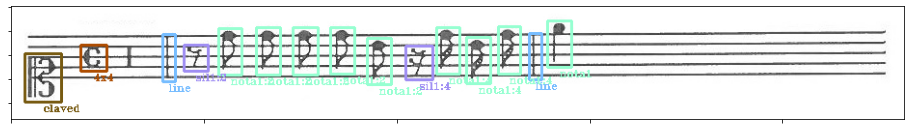

In [8]:
  fig, ax = plt.subplots(1,1,figsize=(16,5))
  ax.imshow(imgEscrita(files[81]),cmap=plt.cm.binary)
  ax.xaxis.set_ticklabels([])
  ax.yaxis.set_ticklabels([])

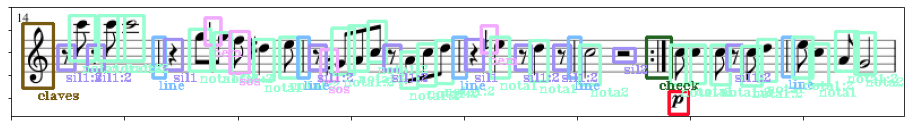

In [9]:
fig, ax = plt.subplots(1,1,figsize=(16,5))
ax.imshow(imgEscrita(files[-3]),cmap=plt.cm.binary)
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
plt.show()

In [10]:
len(files)

119

In [11]:
anot=AnotacionParser('pents/images','pents/annotations')

In [12]:
for x in anot:
  print(x)

pent963.json
pent734.json
pent2021.json
pent1104.json
pent1547.json
pent1350.json
pent1961.json
pent1331.json
pent1135.json
pent322.json
pent1211.json
pent1412.json
pent424.json
pent1661.json
pent1933.json
pent747.json
pent1746.json
pent611.json
pent2164.json
pent510.json
pent1248.json
pent930.json
pent1533.json
super_mario_theme6.json
pent1092.json
pent30.json
pent2168.json
pent1863.json
pent2277.json
pent1026.json
pent1660.json
pent462.json
pent1950.json
pent2276.json
pent1226.json
pent283.json
pent916.json
pent1387.json
super_mario_theme1.json
pent678.json
pent479.json
pent2187.json
pent621.json
pent1122.json
pent1293.json
pent57.json
pent1056.json
pent1740.json
pent209.json
pent2163.json
pent1242.json
super_mario_theme5.json
super_mario_theme4.json
super_mario_theme3.json
pent219.json
pent801.json
pent974.json
pent1954.json
pent1832.json
pent1765.json
pent941.json
pent112.json
pent252.json
pent230.json
pent2060.json
pent2131.json
pent1819.json
pent1118.json
pent135.json
pent1576.js

In [13]:
anot.imageid('pent1042.jpg')

'pent1042'

In [14]:
anot.imageid('pent1042.json')

'pent1042'

In [15]:
anot.filepath('pent1042.json')

Path('pents/images/pent1042.jpg')

In [16]:
anot.image_width_height('pent1042.json')

(926, 117)

In [18]:
print(anot.labels('super_mario_theme5.json'))

[1, 23, 3, 3, 3, 3, 6, 6, 24, 15, 3, 6, 6, 3, 15, 24, 3, 21, 6, 13, 3, 22, 24, 6, 3, 6, 22, 6, 10, 6, 3, 24, 23, 3, 3, 3, 3, 6, 6, 24, 15, 3, 6, 6, 3, 15, 31, 29, 6, 3, 6, 13, 9, 3]


In [34]:
anot.filepath('pent1042.jpg')

Path('pents/images/pent1042.jpg')

In [19]:
print(anot.bboxes('pent1042.json'))

[<BBox (xmin:15, ymin:22, xmax:52, ymax:73)>, <BBox (xmin:49, ymin:35, xmax:67, ymax:60)>, <BBox (xmin:60, ymin:20, xmax:78, ymax:47)>, <BBox (xmin:95, ymin:35, xmax:118, ymax:81)>, <BBox (xmin:146, ymin:37, xmax:166, ymax:81)>, <BBox (xmin:191, ymin:35, xmax:202, ymax:81)>, <BBox (xmin:210, ymin:37, xmax:262, ymax:81)>, <BBox (xmin:268, ymin:34, xmax:280, ymax:81)>, <BBox (xmin:289, ymin:37, xmax:309, ymax:81)>, <BBox (xmin:337, ymin:28, xmax:367, ymax:76)>, <BBox (xmin:362, ymin:56, xmax:374, ymax:69)>, <BBox (xmin:386, ymin:27, xmax:418, ymax:76)>, <BBox (xmin:417, ymin:34, xmax:429, ymax:81)>, <BBox (xmin:439, ymin:44, xmax:460, ymax:89)>, <BBox (xmin:458, ymin:47, xmax:471, ymax:57)>, <BBox (xmin:485, ymin:38, xmax:507, ymax:80)>, <BBox (xmin:524, ymin:34, xmax:535, ymax:80)>, <BBox (xmin:545, ymin:34, xmax:567, ymax:78)>, <BBox (xmin:565, ymin:36, xmax:578, ymax:46)>, <BBox (xmin:593, ymin:27, xmax:615, ymax:73)>, <BBox (xmin:631, ymin:33, xmax:642, ymax:80)>, <BBox (xmin:653, ym

In [12]:
%%capture
train_rs, valid_rs = anot.parse()

INFO     - Autofixing records | icevision.parsers.parser:parse:126


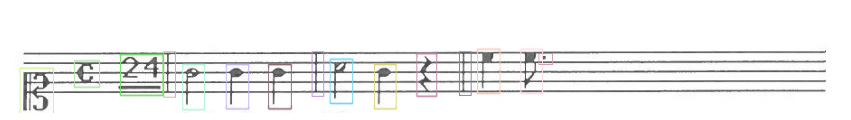

In [13]:
fig, ax = plt.subplots(1,1, figsize=(15, 20))
show_record(train_rs[23], display_label=False,ax=ax)

In [14]:
len(train_rs)/len(files)

0.7983193277310925

## FasterRCNN

In [15]:
class EarlyStoppingMAP(fastai.EarlyStoppingCallback):
  def __init__(self, monitor='valid_loss', comp=None, min_delta=0., patience=5, reset_on_fit=True):
    super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, patience=patience,reset_on_fit=reset_on_fit)

  def before_fit(self):
    self.wait = 0; super().before_fit()

  def after_epoch(self):
    "Compare the value monitored to its best score and maybe stop training."
    val = self.recorder.values[-1][self.idx]
    if self.comp(val, self.best):
      self.best, self.new_best = val, True
    else:
      self.new_best = False


    if self.new_best:
      self.wait = 0
    else:
      self.wait += 1
      if self.wait >= self.patience:
        print(f'No improvement since epoch {self.epoch-self.wait}: early stopping')
        raise fastai.CancelFitException()

class SaveModelMAP(fastai.SaveModelCallback):
  def __init__(self, monitor='valid_loss', comp=None, min_delta=0., fname='model', every_epoch=False, with_opt=False,
               reset_on_fit=True):
    super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, fname=fname,every_epoch=every_epoch, with_opt=with_opt,
                     reset_on_fit=reset_on_fit)

  def _save(self, name):
    super()._save(name)

  def after_epoch(self):
    "Compare the value monitored to its best score and save if best."
    if self.every_epoch:
      self._save(f'{self.fname}_{self.epoch}')
    else:  # every improvement
      val = self.recorder.values[-1][self.idx]
      if self.comp(val, self.best):
        self.best, self.new_best = val, True
      else:
        self.new_best = False

      if self.new_best:
        print(f'Better model found at epoch {self.epoch} with {self.monitor} value: {self.best}.')
        self._save(f'{self.fname}')

  def after_fit(self, **kwargs):
    "Load the best model."
    super().after_fit(**kwargs)


class ReduceLRMAP(fastai.ReduceLROnPlateau):
  def __init__(self, monitor='valid_loss', comp=None, min_delta=0., patience=1, factor=10., min_lr=0,
               reset_on_fit=True):
    super().__init__(monitor=monitor, comp=comp, min_delta=min_delta, patience=patience,factor=factor,min_lr=min_lr,
                     reset_on_fit=reset_on_fit)

  def before_fit(self):
    self.wait = 0; super().before_fit()

  def after_epoch(self):
    "Compare the value monitored to its best score and reduce LR by `factor` if no improvement."
    val = self.recorder.values[-1][self.idx]
    if self.comp(val, self.best):
      self.best, self.new_best = val, True
    else:
      self.new_best = False

    if self.new_best:
      self.wait = 0
    else:
      self.wait += 1
      if self.wait >= self.patience:
        old_lr = self.opt.hypers[-1]['lr']
        for h in self.opt.hypers: h['lr'] = max(h['lr'] / self.factor, self.min_lr)
        self.wait = 0
        if self.opt.hypers[-1]["lr"] < old_lr:
          print(f'Epoch {self.epoch}: reducing lr to {self.opt.hypers[-1]["lr"]}')


def compareM(x1,x2):
  if isinstance(x1,dict):
    x1=float(x1['mAP'])
  if isinstance(x2,dict):
    x2=float(x2['mAP'])
  return np.greater(x1,x2)

In [16]:
model = faster_rcnn.model(num_classes=32)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [52]:
presize = 926
size = 926

In [53]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size), tfms.A.Normalize()])
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize,shift_scale_rotate=None,crop_fn=None, horizontal_flip=None, pad=None), tfms.A.Normalize()])

In [54]:
train_ds = Dataset(train_rs, train_tfms)
valid_ds = Dataset(valid_rs, valid_tfms)

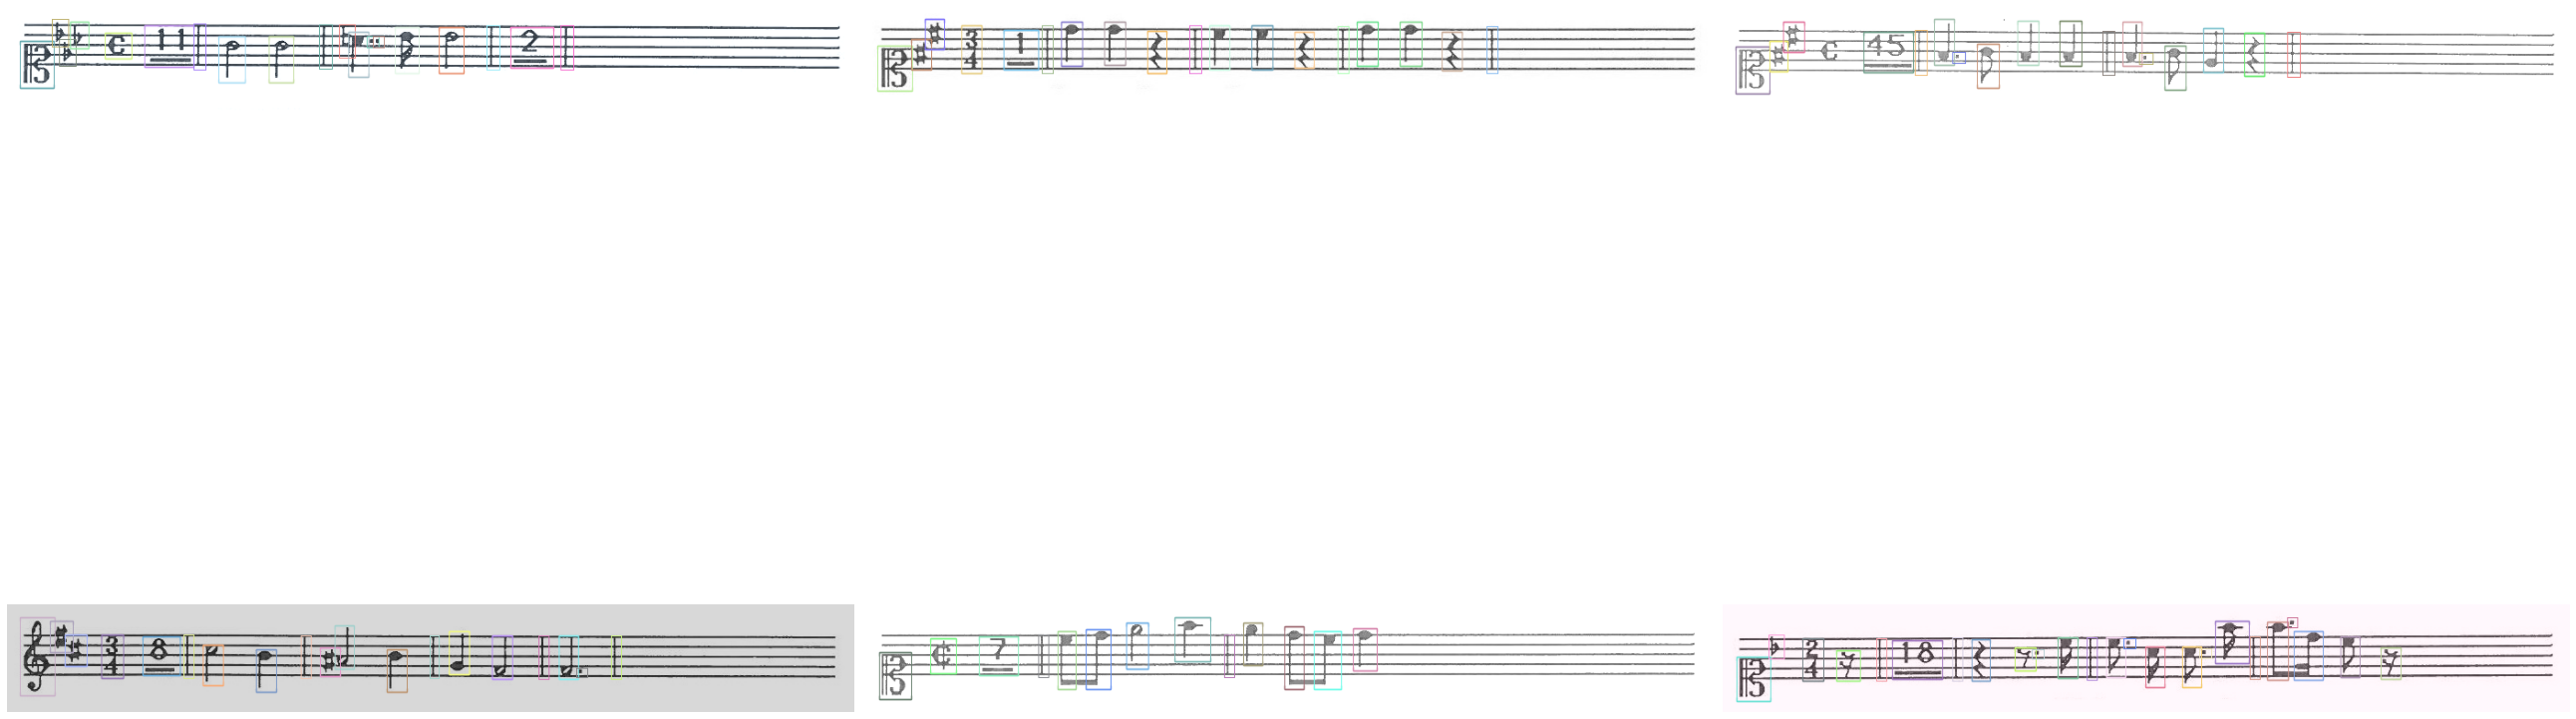

In [55]:
samples = [train_ds[i] for i in range(6)]
show_samples(samples, denormalize_fn=denormalize_imagenet, ncols=3, display_label=False, show=True)

In [56]:
train_dl = faster_rcnn.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = faster_rcnn.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

In [57]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [58]:
saveM=SaveModelMAP(monitor='COCOMetric',fname='FasterRCMM',comp=compareM)
lrReduce=ReduceLRMAP(monitor='COCOMetric',patience=3, factor=10.0, min_lr=0,comp=compareM)
early=EarlyStoppingMAP(monitor='COCOMetric',patience=5,comp=compareM)

In [59]:
learn = faster_rcnn.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics,cbs=[saveM,lrReduce,early])

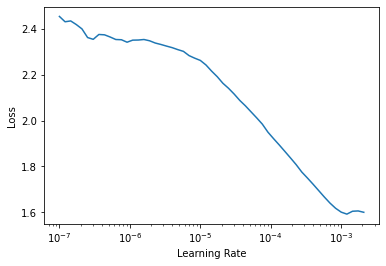

In [60]:
print(learn.recorder.metrics)
(min_lr,step)=learn.lr_find(show_plot=True)

In [61]:
learn.fine_tune(150, lr_min=min_lr, lr_step=step, freeze_epoch=2)

epoch,train_loss,valid_loss,COCOMetric,time
0,1.808484,1.326610,0.248090,00:43


Better model found at epoch 0 with COCOMetric value: 0.24808983867458834.


/usr/local/lib/python3.7/dist-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,COCOMetric,time
0,1.188251,0.969647,0.424161,00:35
1,1.048258,0.820351,0.486989,00:31
2,0.949065,0.746777,0.535074,00:31
3,0.874274,0.706353,0.540170,00:31
4,0.813769,0.652422,0.579867,00:31
5,0.761189,0.612331,0.577260,00:30
6,0.714451,0.594990,0.588676,00:31
7,0.672601,0.579167,0.591241,00:31
8,0.634552,0.567799,0.601468,00:31
9,0.600145,0.562775,0.607098,00:31


Better model found at epoch 0 with COCOMetric value: 0.42416148072769355.
Better model found at epoch 1 with COCOMetric value: 0.4869894047544881.
Better model found at epoch 2 with COCOMetric value: 0.5350736594807977.
Better model found at epoch 3 with COCOMetric value: 0.5401700700468421.
Better model found at epoch 4 with COCOMetric value: 0.5798670356941227.
Better model found at epoch 6 with COCOMetric value: 0.5886758389863881.
Better model found at epoch 7 with COCOMetric value: 0.5912411916304134.
Better model found at epoch 8 with COCOMetric value: 0.6014679388901929.
Better model found at epoch 9 with COCOMetric value: 0.6070982578519658.
Better model found at epoch 10 with COCOMetric value: 0.6293867224860794.
Better model found at epoch 11 with COCOMetric value: 0.6423010815420213.
Better model found at epoch 14 with COCOMetric value: 0.6477611325157462.
Better model found at epoch 16 with COCOMetric value: 0.6544874414254853.
Better model found at epoch 18 with COCOMetric

In [62]:
torch.save(model.state_dict(),'mejor.pth')

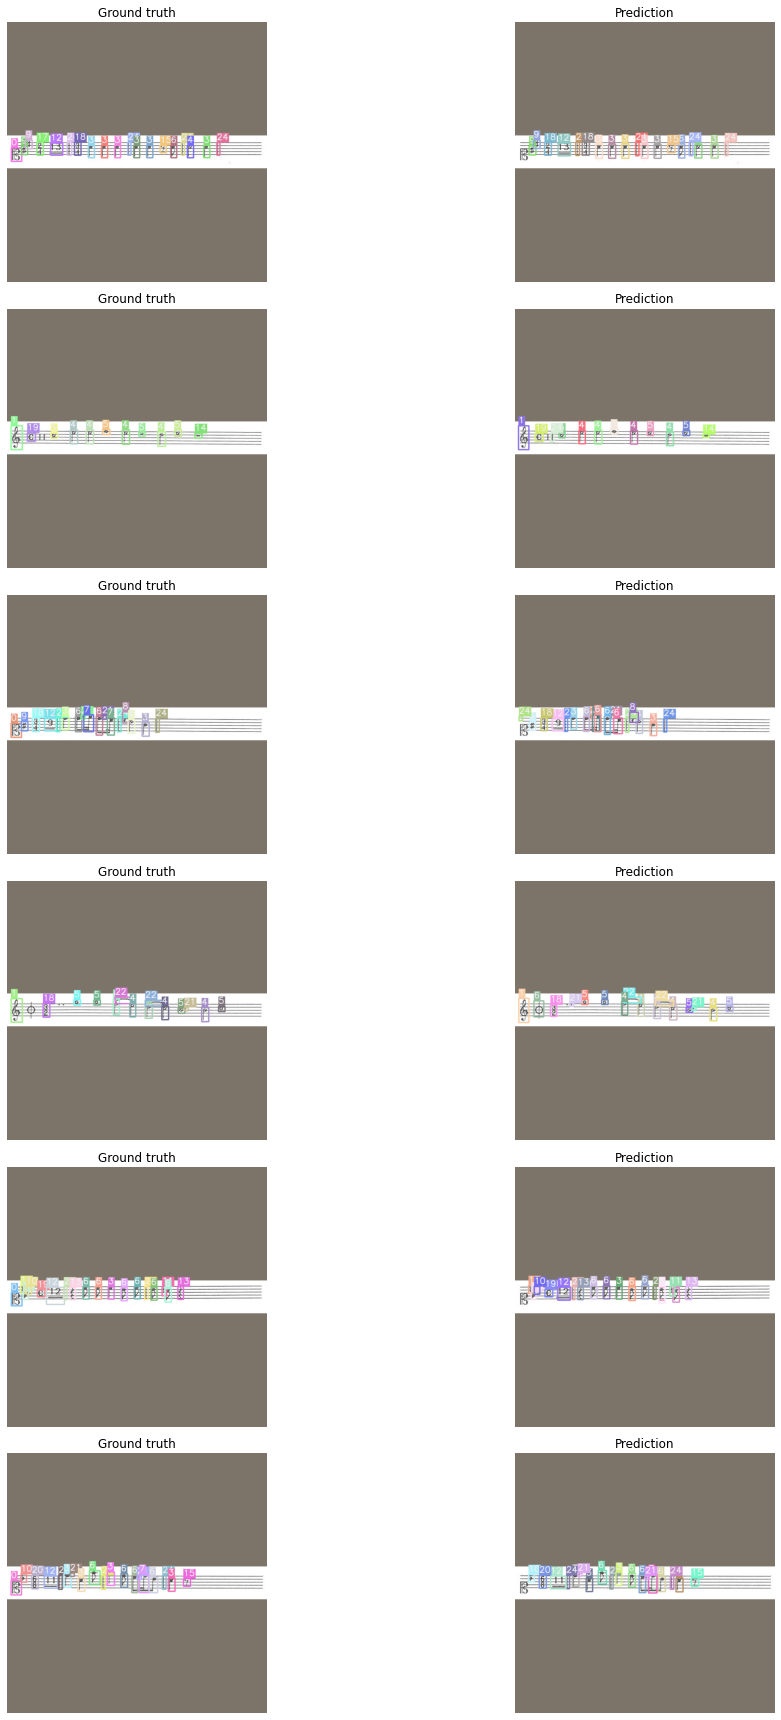

In [63]:
faster_rcnn.show_results(model, valid_ds)

## Inferencia

In [64]:
state_dict = torch.load('mejor.pth')
model = faster_rcnn.model(num_classes=32)

In [65]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [69]:
test1=cv2.imread('/content/prueba.png') # Esta foto está sacada de la web
test2=cv2.imread('/content/prueba2.png') # Esta foto está sacada de la web
test3=cv2.imread('/content/pents/images/pent1211.jpg')

In [70]:
infer_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=600), tfms.A.Normalize()])
infer_ds = Dataset.from_images([test1,test2,test3], infer_tfms)
infer_dl = faster_rcnn.infer_dl(infer_ds, batch_size=1)
samples, preds = faster_rcnn.predict_dl(model=model, infer_dl=infer_dl)

  0%|          | 0/3 [00:00<?, ?it/s]

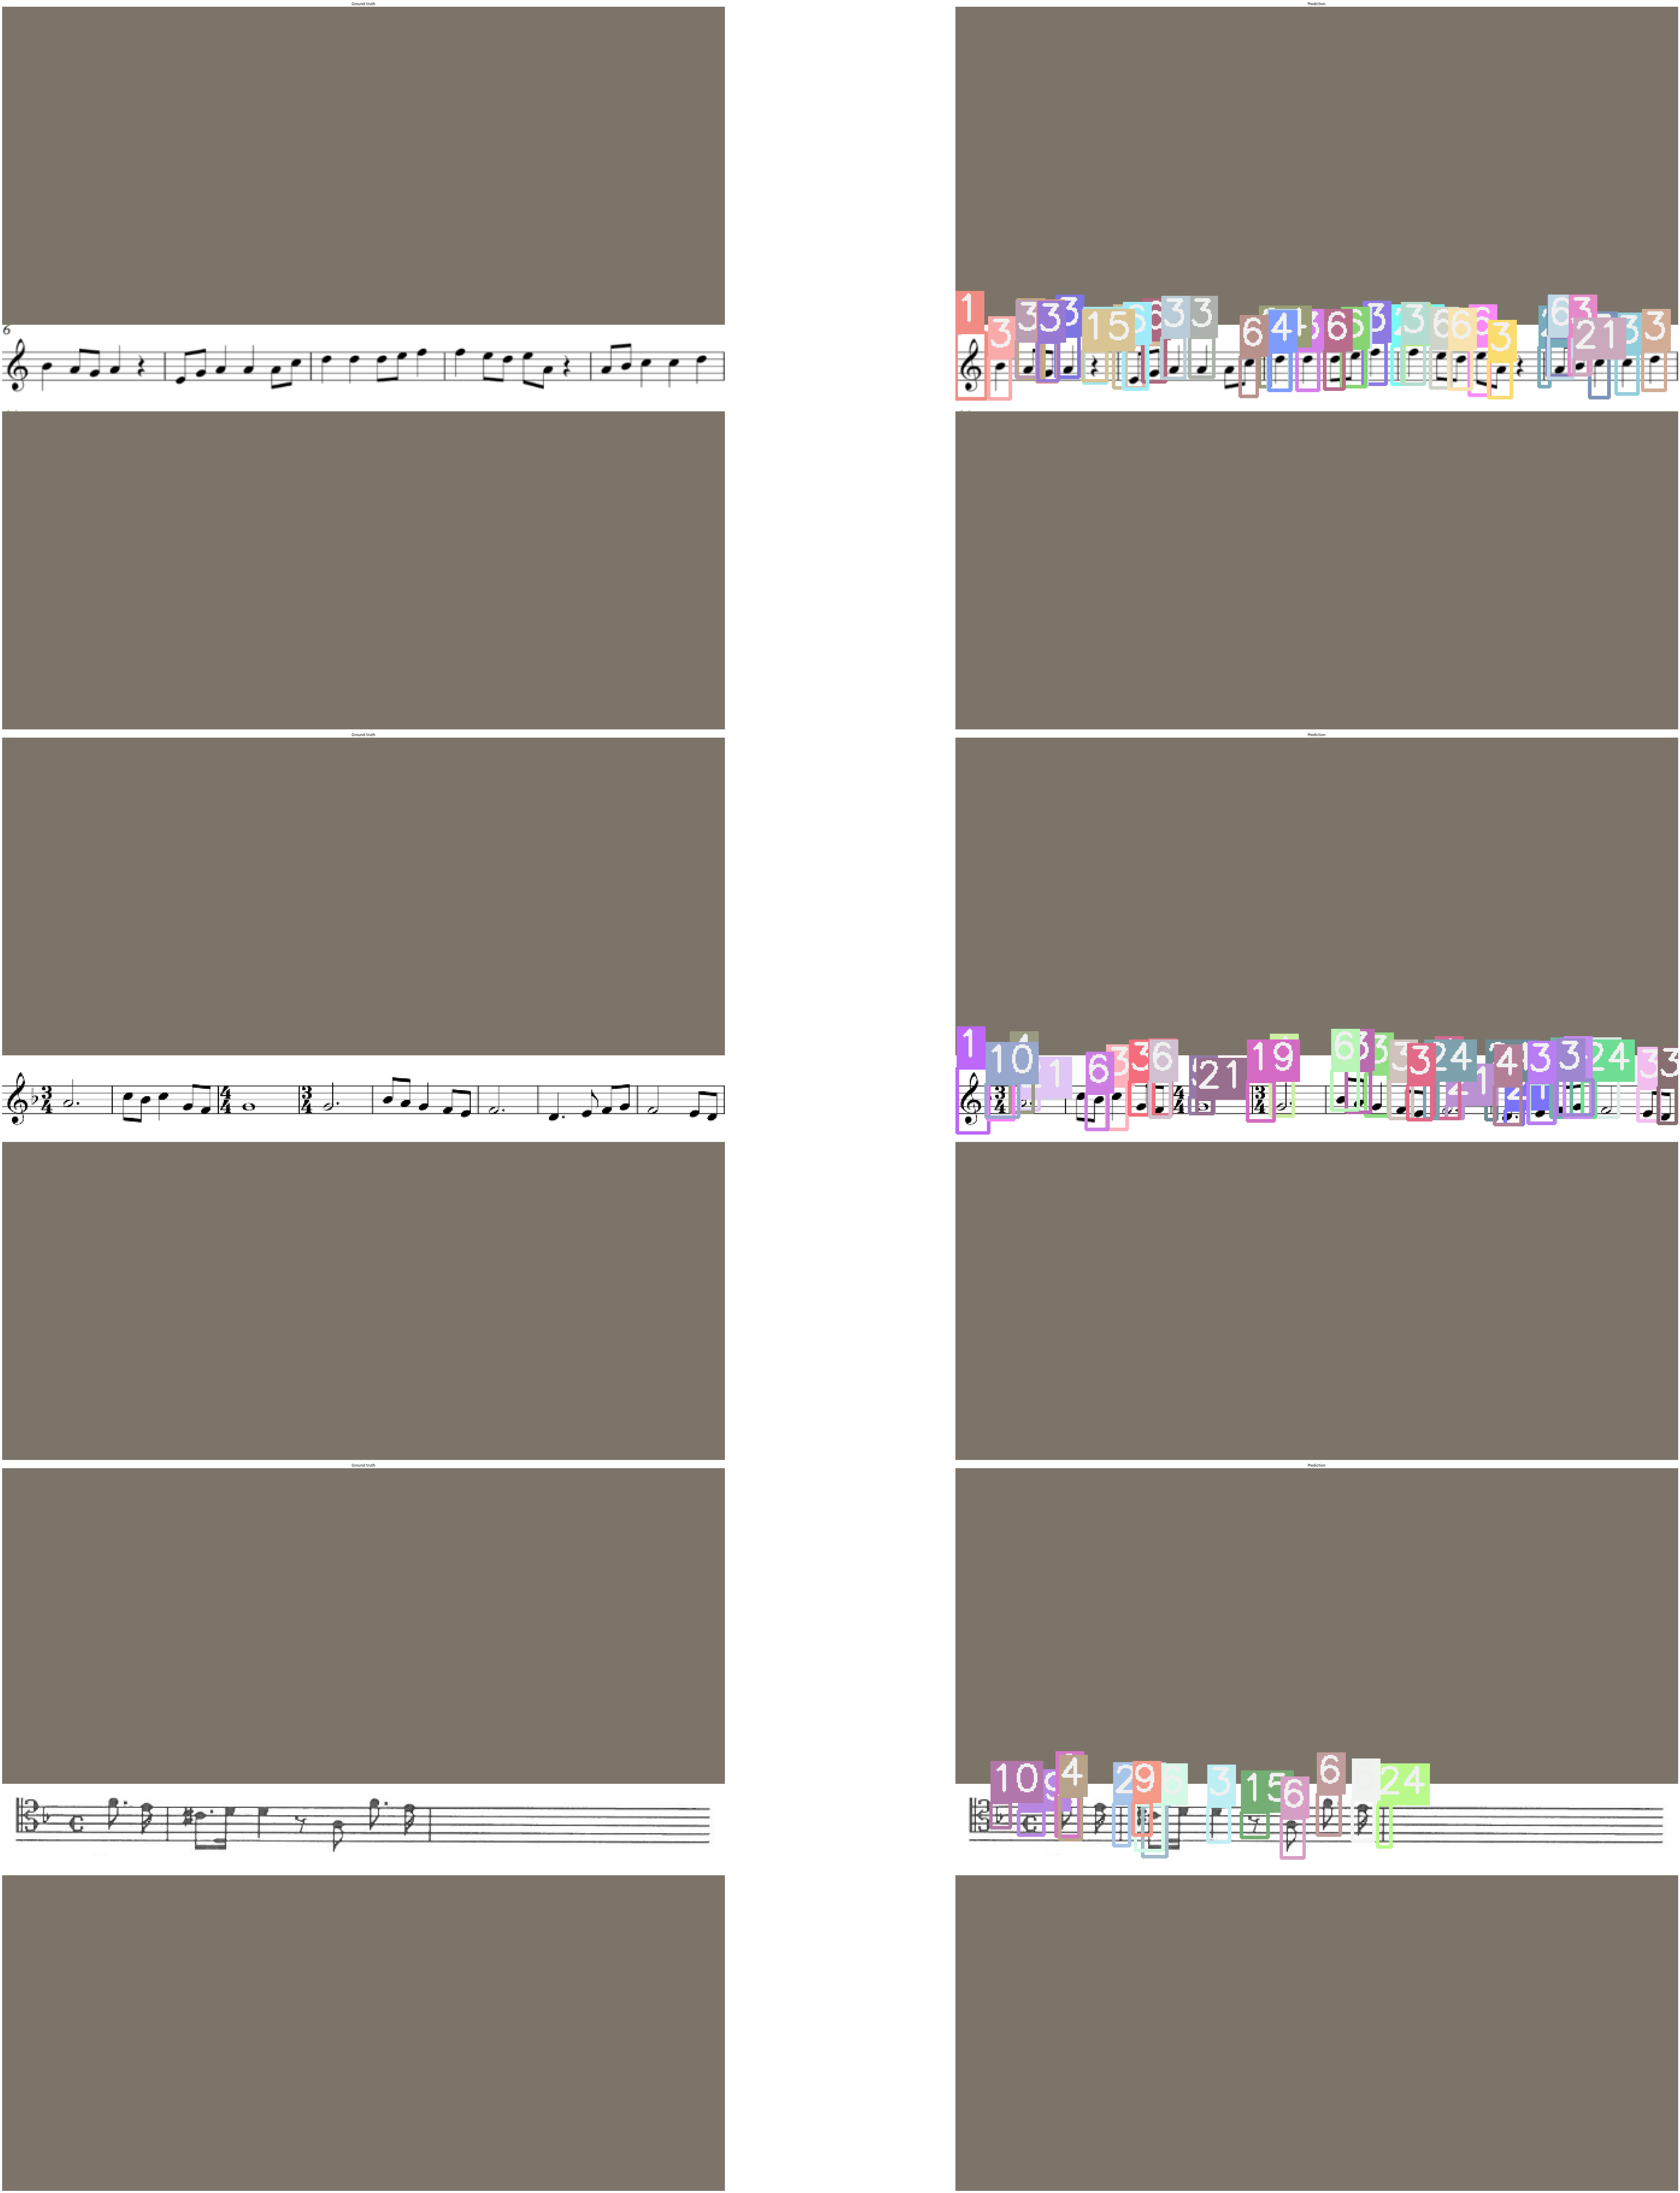

In [71]:
show_preds(samples=samples, preds=preds,denormalize_fn=denormalize_imagenet,figsize=(100,100))